In [ ]:
#!pip install pooch
#!conda install pooch

In [118]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
import warnings
import time
import glob
import seaborn as sns
import dask
import geopandas as gpd
import rasterio.mask
from shapely.geometry import mapping
import rioxarray
from rasterio import features
from affine import Affine
from pyhdf.SD import SD, SDC
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")

# loading,slicing,shaping,filtering and regridding

In [6]:
#Loading AOD Dataset for testing 
aod_file = glob.glob('./Data/AOD/*')
aod_insat3D = glob.glob(aod_file[0]+'/*')
aod_insat3DR = glob.glob(aod_file[1]+'/*')
ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

#slicing
ds1_3DR = ds_3DR.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()
ds1_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()

#merging
ds_merged = xr.concat([ds1_3DR, ds1_3D], dim='time').sortby('time')

In [7]:
aod_modis_dir = glob.glob(aod_file[2]+'/*')

# MODIS DIR contain sub folder with no time dimension
# Create empty list to store file path with time stamp
aod_modis_path = []
time_stamp = []

# Mention Starting Year
start_year = np.datetime64('2018')

for path in aod_modis_dir:
    
    aod_modis_path.append(glob.glob(path+'/*'))
    day_no  = int(path.split('\\')[-1]) # Day number according to file name i,e 001,002,003,...365
    time_stamp.append(start_year + np.timedelta64(day_no-1, 'D')) # add timestamp to that particular file index

aod_modis_path[:5],time_stamp[:5]

([['./Data/AOD\\MODIS_2018\\001\\MOD08_D3.A2018001.061.2018003215357.hdf'],
  ['./Data/AOD\\MODIS_2018\\002\\MOD08_D3.A2018002.061.2018003215942.hdf'],
  ['./Data/AOD\\MODIS_2018\\003\\MOD08_D3.A2018003.061.2018004083950.hdf'],
  ['./Data/AOD\\MODIS_2018\\004\\MOD08_D3.A2018004.061.2018005083354.hdf'],
  ['./Data/AOD\\MODIS_2018\\005\\MOD08_D3.A2018005.061.2018008181118.hdf']],
 [numpy.datetime64('2018-01-01'),
  numpy.datetime64('2018-01-02'),
  numpy.datetime64('2018-01-03'),
  numpy.datetime64('2018-01-04'),
  numpy.datetime64('2018-01-05')])

In [8]:
# Declare Datafield Name
DATAFIELD_NAME = 'AOD_550_Dark_Target_Deep_Blue_Combined_Mean'

# Temporary list to store data to make xarray dataset
DATA = []
TIME = []
LAT = []
LON = []

# Read MODIS file
for idx, FILE_NAME in  enumerate(aod_modis_path):
        
    hdf = SD(*FILE_NAME, SDC.READ)
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)
    
    # Read dataset.
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)

    # Read lat/lon.
    xdim = hdf.select('XDim')
    lon = xdim[:].astype(np.double)

    ydim = hdf.select('YDim')
    lat = ydim[:].astype(np.double)
    
    # Retrieve attributes.
    attrs = data_raw.attributes(full=1)
    lna=attrs["long_name"]
    long_name = lna[0]
    aoa=attrs["add_offset"]
    add_offset = aoa[0]
    fva=attrs["_FillValue"]
    _FillValue = fva[0]
    sfa=attrs["scale_factor"]
    scale_factor = sfa[0]        
    ua=attrs["units"]
    units = ua[0]

    # Fill 9999 with NaN value
    data[data == _FillValue] = np.nan
    data =  scale_factor * (data - add_offset) 
    datam = np.ma.masked_array(data, np.isnan(data))
    
    # Store result in DATA and TIME list
    TIME.append(time_stamp[idx])
    DATA.append(data)
    

# Make np array for list
TIME = np.array(TIME)
LAT = np.array(lat)
LON = np.array(lon)
DATA = np.array(DATA)

print("Data file is ready !!!")

Data file is ready !!!


In [9]:
# Create Modis Dataset
ds_modis = xr.Dataset(
        {
            'AOD': (['time','latitude', 'longitude'], DATA),
            'time': (['time'],TIME),
            'latitude': (['latitude'], LAT),
            'longitude': (['longitude'], LON),
        }
    )


ds_modis = ds_modis.sel(latitude=slice(39,8),longitude=slice(67,98))

In [10]:
ds_merged

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

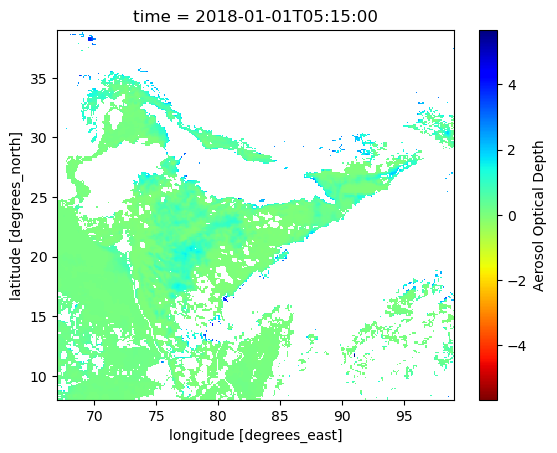

In [11]:
ds_merged.AOD.isel(time=0).plot(cmap='jet_r')

In [12]:
# Shaping dataset
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [13]:
sf_dir = './Data/India_Boundary/India_Boundary.shp'

ds_mask = add_shape_coord_from_data_array(ds_merged, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_merged_shaped = ds_mask.drop_vars('MASK')

ds_mask = add_shape_coord_from_data_array(ds_modis, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_modis_shaped = ds_mask.drop_vars('MASK')

In [14]:
ds_merged_shaped

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

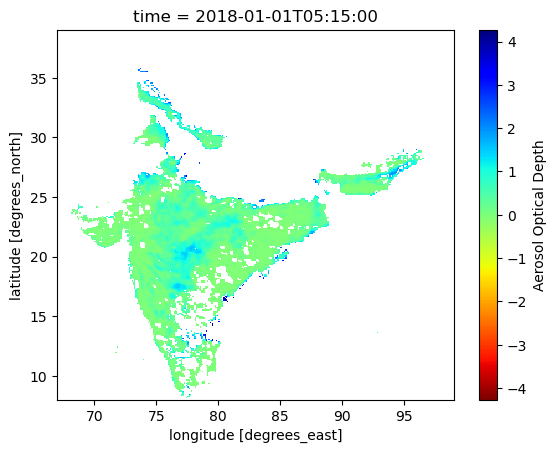

In [15]:
ds_merged_shaped.AOD.isel(time=0).plot(cmap='jet_r')

# 2-sigma rule Filter

In [16]:
def twoSig_pos_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean + 1*std
    return res.where(count>=6)

def twoSig_neg_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean - 1*std
    return res.where(count>=6)

def twoSigfilter(ds):
   
    # Converting hourly to daily timestamp
    daily_timestamp = ds.time.dt.floor('1D')
    unique_day = np.unique(daily_timestamp)
    
    # COUNT PLOT ON TIME DIMENSION
    ds_day_count = ds.groupby(daily_timestamp).count(dim='time').rename({'floor':'time'})

    # Calculating mean + 2*sigma
    ds_twoSig_pos= ds.groupby(daily_timestamp).apply(twoSig_pos_rule).rename({'floor': 'time'})

    # Calculating mean - 2*sigma
    ds_twoSig_neg= ds.groupby(daily_timestamp).apply(twoSig_neg_rule).rename({'floor': 'time'})

    # re-arrange coordinates
    ds_twoSig_pos = ds_twoSig_pos[['time','latitude','longitude','AOD']]
    ds_twoSig_neg = ds_twoSig_neg[['time','latitude','longitude','AOD']]

    # Assigning Time Coordinate value as data_set timestamp since it is 0,1,..365 format
    
    print(len(ds_day_count.time.values))
    ds_twoSig_pos.coords['time'] = unique_day
    ds_twoSig_neg.coords['time'] = unique_day
    
    # Flooring hourly time to day time and generate duplicate time index for same hour
    ds.coords['time'] = ds.time.dt.floor('1D')

    # Create a mask for filtering out the data
    mask = (ds['AOD'] < ds_twoSig_pos.sel(time=ds['time'])) & (ds['AOD'] > ds_twoSig_neg.sel(time=ds['time']))

    # Apply the mask to filter out the data
    filtered_data = ds.where(mask)
    
    return filtered_data

In [17]:
ds_merged_filter = twoSigfilter(ds_merged_shaped)

365


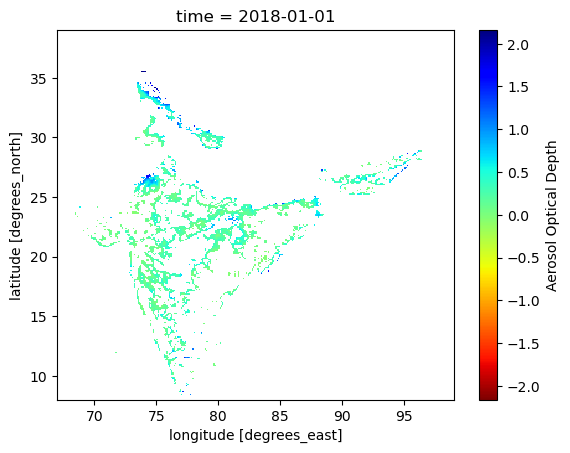

In [18]:
ds_merged_filter.AOD.isel(time=0).plot(cmap='jet_r')

In [205]:
# regridding 
def regrid_1(ds):
    minx = ds_modis_daily.longitude.min().item()
    maxx = ds_modis_daily.longitude.max().item()
    miny = ds_modis_daily.latitude.min().item()
    maxy = ds_modis_daily.latitude.max().item()


    out_res = 1
    interval_window = out_res/2
    # set up new lat/lon grid
    new_grid_x = np.arange(
        np.ceil(minx / out_res) * out_res,
        (np.floor(maxx / out_res) + 0.5) * out_res,
        out_res
    )
    new_grid_y = np.arange(
        np.ceil(miny / out_res) * out_res,
        (np.floor(maxy / out_res) + 0.5) * out_res,
        out_res
    )
    
    
    return ds.interp(longitude=new_grid_x[:] + interval_window, latitude=new_grid_y[:] + interval_window, method="nearest")

def regrid_2(ds):

    out_res = 1
    minx = ds.longitude.min().item()
    maxx = ds.longitude.max().item()
    miny = ds.latitude.min().item()
    maxy = ds.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    
    print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= 0.5,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb

def regrid_3(ds):

    out_res = 1
    minx = ds.longitude.min().item()
    maxx = ds.longitude.max().item()
    miny = ds.latitude.min().item()
    maxy = ds.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    
    print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= 0.75,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb

def regrid_4(ds):

    out_res = 1
    minx = ds.longitude.min().item()
    maxx = ds.longitude.max().item()
    miny = ds.latitude.min().item()
    maxy = ds.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    
    print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= 0.25,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb

def regrid_5(ds):

    out_res = 1
    minx = ds.longitude.min().item()
    maxx = ds.longitude.max().item()
    miny = ds.latitude.min().item()
    maxy = ds.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    
    print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= 0,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb
def regrid_6(ds):

    out_res = 1
    minx = ds_modis_daily.longitude.min().item()
    maxx = ds_modis_daily.longitude.max().item()
    miny = ds_modis_daily.latitude.min().item()
    maxy = ds_modis_daily.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    
    print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= 0.10,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb

In [20]:
ds_merged_daily  = ds_merged_filter.resample(time='1D').mean()
ds_modis_daily = ds_modis_shaped.resample(time='1D').mean()

In [206]:
ds_merged_coarse_1  = regrid_1(ds_merged_daily)
ds_merged_coarse_1

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 30, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * longitude  (longitude) float64 68.5 69.5 70.5 71.5 ... 94.5 95.5 96.5 97.5
  * latitude   (latitude) float64 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [22]:
ds_merged_coarse_2  = regrid_2(ds_merged_daily)
ds_merged_coarse_2

[66.55 67.55 68.55 69.55 70.55 71.55 72.55 73.55 74.55 75.55 76.55 77.55
 78.55 79.55 80.55 81.55 82.55 83.55 84.55 85.55 86.55 87.55 88.55 89.55
 90.55 91.55 92.55 93.55 94.55 95.55 96.55 97.55 98.55 99.55] [ 7.55  8.55  9.55 10.55 11.55 12.55 13.55 14.55 15.55 16.55 17.55 18.55
 19.55 20.55 21.55 22.55 23.55 24.55 25.55 26.55 27.55 28.55 29.55 30.55
 31.55 32.55 33.55 34.55 35.55 36.55 37.55 38.55 39.55]


<xarray.Dataset>
Dimensions:    (time: 365, latitude: 32, longitude: 33)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.05 9.05 10.05 11.05 ... 37.05 38.05 39.05
  * longitude  (longitude) float64 67.05 68.05 69.05 70.05 ... 97.05 98.05 99.05
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [23]:
ds_merged_coarse_3  = regrid_3(ds_merged_daily)
ds_merged_coarse_3

[66.55 67.55 68.55 69.55 70.55 71.55 72.55 73.55 74.55 75.55 76.55 77.55
 78.55 79.55 80.55 81.55 82.55 83.55 84.55 85.55 86.55 87.55 88.55 89.55
 90.55 91.55 92.55 93.55 94.55 95.55 96.55 97.55 98.55 99.55] [ 7.55  8.55  9.55 10.55 11.55 12.55 13.55 14.55 15.55 16.55 17.55 18.55
 19.55 20.55 21.55 22.55 23.55 24.55 25.55 26.55 27.55 28.55 29.55 30.55
 31.55 32.55 33.55 34.55 35.55 36.55 37.55 38.55 39.55]


<xarray.Dataset>
Dimensions:    (time: 365, latitude: 32, longitude: 33)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.05 9.05 10.05 11.05 ... 37.05 38.05 39.05
  * longitude  (longitude) float64 67.05 68.05 69.05 70.05 ... 97.05 98.05 99.05
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [41]:
ds_merged_coarse_4  = regrid_4(ds_merged_daily)
ds_merged_coarse_4

[66.55 67.55 68.55 69.55 70.55 71.55 72.55 73.55 74.55 75.55 76.55 77.55
 78.55 79.55 80.55 81.55 82.55 83.55 84.55 85.55 86.55 87.55 88.55 89.55
 90.55 91.55 92.55 93.55 94.55 95.55 96.55 97.55 98.55 99.55] [ 7.55  8.55  9.55 10.55 11.55 12.55 13.55 14.55 15.55 16.55 17.55 18.55
 19.55 20.55 21.55 22.55 23.55 24.55 25.55 26.55 27.55 28.55 29.55 30.55
 31.55 32.55 33.55 34.55 35.55 36.55 37.55 38.55 39.55]


<xarray.Dataset>
Dimensions:    (time: 365, latitude: 32, longitude: 33)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.05 9.05 10.05 11.05 ... 37.05 38.05 39.05
  * longitude  (longitude) float64 67.05 68.05 69.05 70.05 ... 97.05 98.05 99.05
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [174]:
ds_merged_coarse_5  = regrid_5(ds_merged_daily)
ds_merged_coarse_5

In [189]:
ds_merged_coarse_6  = regrid_6(ds_merged_daily)
ds_merged_coarse_6

[67. 68. 69. 70. 71. 72. 73. 74. 75. 76. 77. 78. 79. 80. 81. 82. 83. 84.
 85. 86. 87. 88. 89. 90. 91. 92. 93. 94. 95. 96. 97. 98.] [ 8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36. 37. 38. 39.]


<xarray.Dataset>
Dimensions:    (time: 365, latitude: 31, longitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.5 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [167]:
ds_modis_daily

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 31, longitude: 31)
Coordinates:
  * latitude   (latitude) float64 38.5 37.5 36.5 35.5 34.5 ... 11.5 10.5 9.5 8.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
Data variables:
    AOD        (time, latitude, longitude) float64 nan nan nan ... nan nan nan

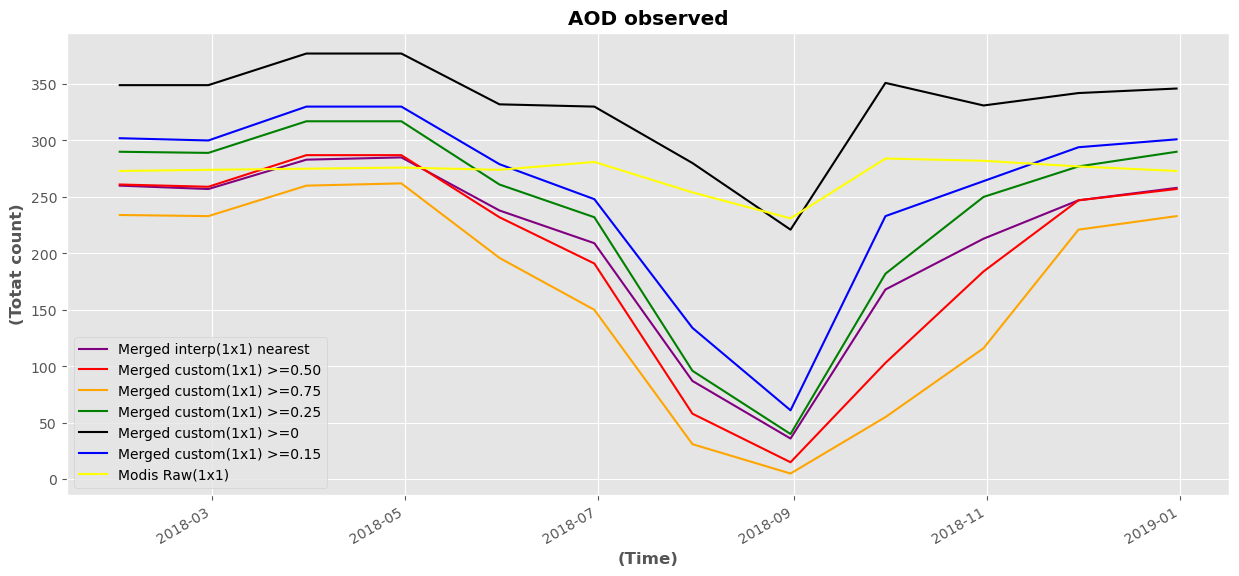

In [195]:
fig, ax = plt.subplots(figsize=(15,6) )
    
data1_mean = ds_merged_coarse_1['AOD'].resample(time = '1M').mean().count(dim=('latitude', 'longitude'))
data2_mean = ds_merged_coarse_2['AOD'].resample(time = '1M').mean().count(dim=('latitude', 'longitude'))
data3_mean = ds_merged_coarse_3['AOD'].resample(time = '1M').mean().count(dim=('latitude', 'longitude'))
data4_mean = ds_merged_coarse_4['AOD'].resample(time = '1M').mean().count(dim=('latitude', 'longitude'))
data5_mean = ds_merged_coarse_5['AOD'].resample(time = '1M').mean().count(dim=('latitude', 'longitude'))
data6_mean = ds_merged_coarse_6['AOD'].resample(time = '1M').mean().count(dim=('latitude', 'longitude'))

data7_mean = ds_modis_daily['AOD'].resample(time = '1M').mean().count(dim=('latitude', 'longitude'))

colors = ['purple', 'red', 'orange', 'green', 'black', 'blue', 'yellow']

# Set the line colors for each plot using the colors list
for i, (data, label) in enumerate(zip([data1_mean, data2_mean, data3_mean, data4_mean, data5_mean,data6_mean,data7_mean],
                                      ['Merged interp(1x1) nearest', 'Merged custom(1x1) >=0.50',
                                       'Merged custom(1x1) >=0.75', 'Merged custom(1x1) >=0.25',
                                       'Merged custom(1x1) >=0','Merged custom(1x1) >=0.15',
                                       'Modis Raw(1x1)'])):
    data.plot.line(ax=ax, label=label, color=colors[i])


ax.legend()
ax.set_xlabel('(Time)',weight='bold')
ax.set_ylabel('(Totat count)',weight='bold')
ax.set_title(f'AOD observed',weight='bold')

plt.style.use('ggplot')

#plt.savefig('./plots/aod_plot/Insat_vs_Modis/raw_vs_filter_montly.png')
plt.show()

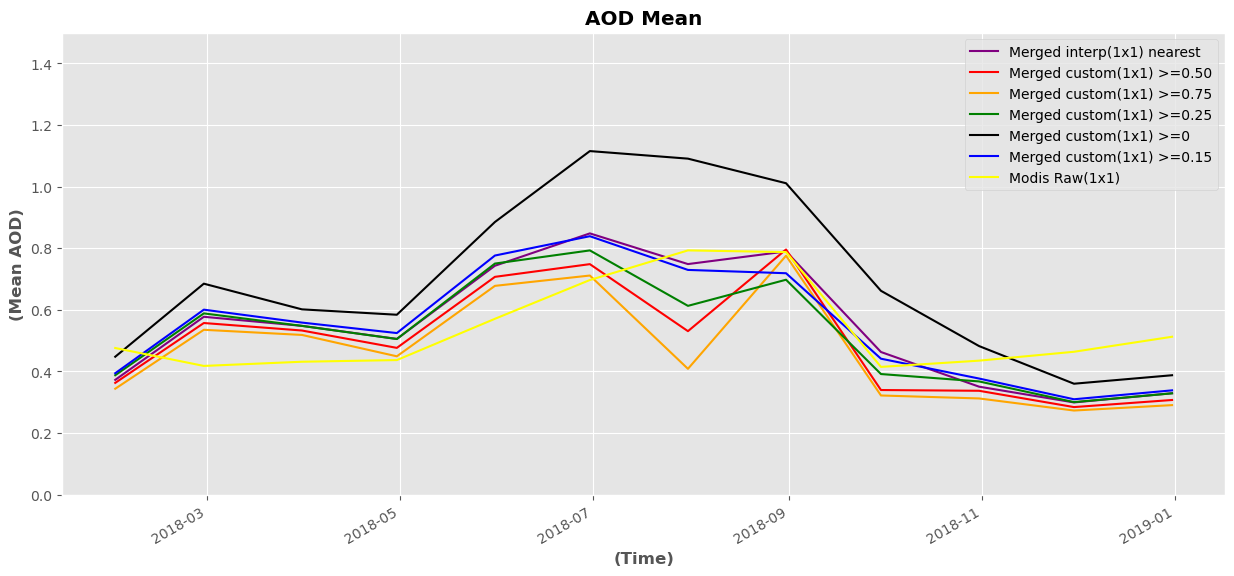

In [198]:
fig, ax = plt.subplots(figsize=(15,6) )
    
data1_mean = ds_merged_coarse_1['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data2_mean = ds_merged_coarse_2['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data3_mean = ds_merged_coarse_3['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data4_mean = ds_merged_coarse_4['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data5_mean = ds_merged_coarse_5['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data6_mean = ds_merged_coarse_6['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))

data7_mean = ds_modis_daily['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))

colors = ['purple', 'red', 'orange', 'green', 'black', 'blue', 'yellow']

# Set the line colors for each plot using the colors list
for i, (data, label) in enumerate(zip([data1_mean, data2_mean, data3_mean, 
                                       data4_mean, data5_mean, data6_mean,
                                       data7_mean],
                                      ['Merged interp(1x1) nearest', 'Merged custom(1x1) >=0.50',
                                       'Merged custom(1x1) >=0.75', 'Merged custom(1x1) >=0.25',
                                       'Merged custom(1x1) >=0','Merged custom(1x1) >=0.15',
                                       'Modis Raw(1x1)'])):
    data.plot.line(ax=ax, label=label, color=colors[i])


ax.legend()
ax.set_xlabel('(Time)',weight='bold')
ax.set_ylabel('(Mean AOD)',weight='bold')
ax.set_title(f'AOD Mean',weight='bold')

ax.set_ylim(0,1.5)
plt.style.use('ggplot')

#plt.savefig('./plots/aod_plot/Insat_vs_Modis/Different_regrid_method.png')
plt.show()

In [204]:
#ds_merged_coarse.AOD.sel(time='2018-09-01').plot(cmap='jet_r')
ds_merged_coarse_1

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 29, longitude: 29)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * longitude  (longitude) float64 68.5 69.5 70.5 71.5 ... 93.5 94.5 95.5 96.5
  * latitude   (latitude) float64 9.5 10.5 11.5 12.5 ... 34.5 35.5 36.5 37.5
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [81]:
ds2 = ds_modis_daily

R-squared score: -0.826


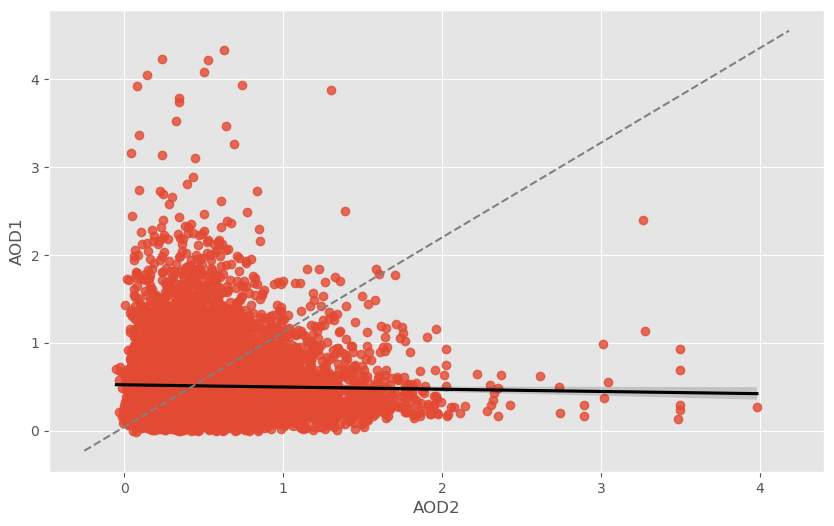

In [202]:
ds1 = ds_merged_coarse_6
ds2 = ds_modis_daily

ds1 = ds1.reindex(latitude=ds1.latitude[::-1])

data = {
        'AOD1': ds1.AOD.values.flatten(),
        'AOD2': ds2.AOD.values.flatten(),
       }
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)
df = df.dropna()
fig, ax = plt.subplots(figsize=(10,6))
# Plot the regression line with black color
sns.regplot(x='AOD2', y='AOD1', data=df, line_kws={'color': 'black'},ax=ax)

# Draw an ideal slope with gray color
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x_range = [xmin, xmax]
y_range = [ymin, ymax]
plt.plot(x_range, y_range, color='gray', linestyle='--')

# Calculate the R-squared score and print it
r2 = r2_score(df['AOD1'], df['AOD2'])
print(f"R-squared score: {r2:.3f}")

plt.show()

In [207]:
ds1 = ds_merged_coarse_1
ds2 = ds_modis_daily

ds1 = ds1.reindex(latitude=ds1.latitude[::-1])

data = {
        'AOD1': ds1.AOD.values.flatten(),
        'AOD2': ds2.AOD.values.flatten(),
       }
# Create a DataFrame from the dictionary
df = pd.DataFrame(data)
df = df.dropna()
fig, ax = plt.subplots(figsize=(6,6))
# Plot the regression line with black color
sns.regplot(x='AOD2', y='AOD1', data=df, line_kws={'color': 'black'},ax=ax)

# Draw an ideal slope with gray color
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
x_range = [xmin, xmax]
y_range = [ymin, ymax]
plt.plot(x_range, y_range, color='gray', linestyle='--')

# Calculate the R-squared score and print it
r2 = r2_score(df['AOD1'], df['AOD2'])
print(f"R-squared score: {r2:.3f}")

plt.show()

ValueError: All arrays must be of the same length

In [ ]:
# plotting

fig, ax = plt.subplots(figsize=(15,6) )
    
data1_mean = ds_merged_shaped['AOD'].resample(time = '1D').mean().mean(dim=('latitude', 'longitude'))
data2_mean = ds_merged_daily['AOD'].resample(time = '1D').mean().mean(dim=('latitude', 'longitude'))
data3_mean = ds_merged_coarse['AOD'].mean(dim=('latitude', 'longitude'))
data4_mean = ds_modis_daily['AOD'].mean(dim=('latitude', 'longitude'))



data1_mean.plot.line(ax=ax, label='Merged Raw(0.1x0.1)')
data2_mean.plot.line(ax=ax, label='Merged Filter(0.1x0.1)')
data3_mean.plot.line(ax=ax, label='Merged Regrid(1x1)')
data4_mean.plot.line(ax=ax, label='Modis Raw(1x1)')


ax.legend()
ax.set_xlabel('(Time)',weight='bold')
ax.set_ylabel('(Mean AOD)',weight='bold')
ax.set_title(f'AOD Mean',weight='bold')

plt.style.use('ggplot')
plt.savefig('./plots/aod_plot/Insat_vs_Modis/raw_vs_filter_daily.png')
plt.show()

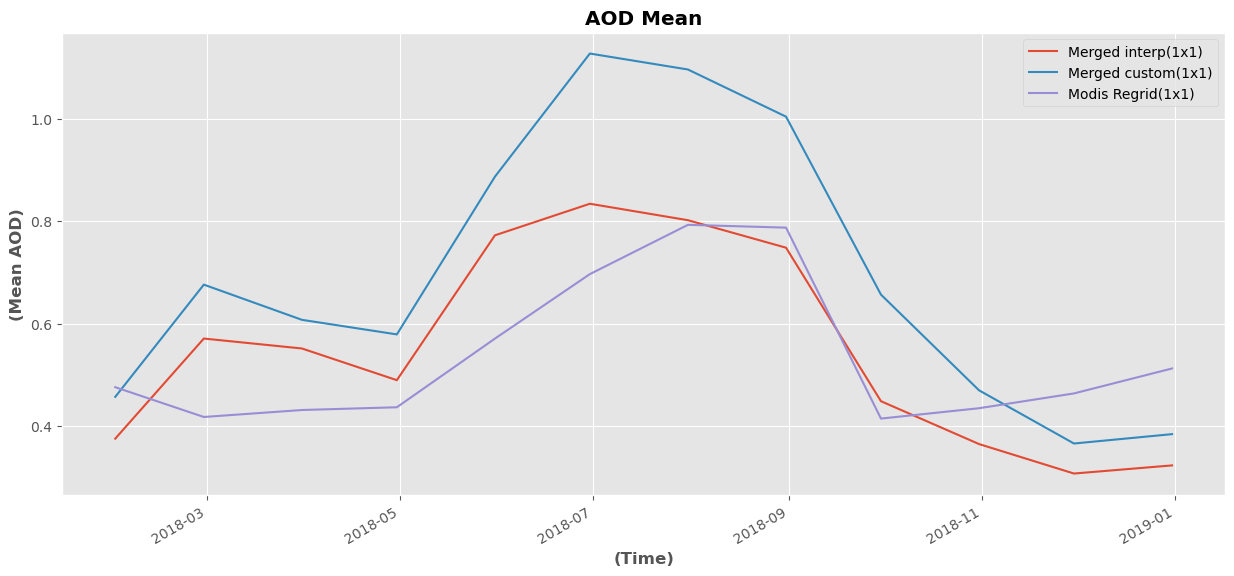

In [20]:
fig, ax = plt.subplots(figsize=(15,6) )
    
data1_mean = ds_merged_coarse_1['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data2_mean = ds_merged_coarse_2['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data3_mean = ds_modis_daily['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))



data1_mean.plot.line(ax=ax, label='Merged interp(1x1)')
data2_mean.plot.line(ax=ax, label='Merged custom(1x1)')
data3_mean.plot.line(ax=ax, label='Modis Regrid(1x1)')

ax.legend()
ax.set_xlabel('(Time)',weight='bold')
ax.set_ylabel('(Mean AOD)',weight='bold')
ax.set_title(f'AOD Mean',weight='bold')

plt.style.use('ggplot')


#plt.savefig('./plots/aod_plot/Insat_vs_Modis/raw_vs_filter_montly.png')
plt.show()

## REINDEXING

In [ ]:
data1 = data1.reindex(y=data1.y[::-1])
data1.to_dataframe()

In [ ]:
data2.to_dataframe()

In [ ]:
ds = xr.concat([data1,data2],dim='z')
print(np.isnan(ds['pm2p5']).sum())

In [ ]:
ds.to_dataframe()

## COARSEN

In [ ]:
regrid_ds = ds.coarsen(x=2,y=2,boundary='pad').mean()
#regrid_ds['x'] = ds['x'].data[::2]
#regrid_ds['x'] = ds['x'].data[::2]
#regrid_ds['y'] = ds['y'].data[::3]
#regrid_ds['y'] = regrid_ds['y'].values[::factor]
regrid_ds.to_dataframe()

## Testing on AOD Data

## Reading Shape file using GEOPANDAS

In [ ]:
ds_merged.AOD.isel(time=1000).plot(cmap = 'jet_r')

In [ ]:
# india_boundary = geopandas.read_file('./Data/India_Boundary/India_Boundary.shp')

# # ds_merged1 = ds_merged.rio.write_crs('epsg:4326')
# # ds_merged2 = ds_merged1.rio.clip(india_boundary.geometry,crs='epsg:4326')
# # ds_merged2.AOD.isel(time=1000).plot(cmap = 'jet_r')

# lat = india_boundary.geometry.y
# lon = india_boundary.geometry.x

# lat

In [ ]:
ds_merged1 = ds_merged.where(ds_merged.AOD > 0)
ds_merged1

In [ ]:
ds_merged2 = ds_merged1.reindex(latitude=ds_merged1.latitude[::-1])
ds_merged2

In [ ]:
## RESAMPLING time dims to montly data
# ds_merged3 = ds_merged2.resample(time='1M').mean()
# ds_merged3

In [ ]:
ds_compute = ds_merged2.compute()

In [ ]:
ds_compute

## Counting number of valid data count in each grid cell

In [ ]:
out_res = float(0.25)

interval_window = out_res/2 
new_lat = np.arange(8-interval_window, 38 + out_res, out_res) # Latitude label i.e 8,..,38
new_lon = np.arange(68-interval_window, 98 + out_res, out_res) # longitude Label i.e 68,..,98


#Counting valid data point and divide it by total data(missing+non-missing)
gb = ds_compute.groupby_bins("latitude", bins=new_lat).apply(
    lambda x: x.groupby_bins("longitude", bins=new_lon).apply(
        lambda y: np.round((y.count(dim='time') / ( y.count(dim='time') + y.isnull().sum(dim='time') ) )*100)
        )
    )
print(gb.AOD.data.shape)
#valid_percentages = gb['AOD'].values.flatten()

In [ ]:
gb

## Take avg for each grid cell if the number of valid data count are more than threshold data count

In [ ]:
out_res = float(0.25)

interval_window = out_res/2 
new_lat = np.arange(8-interval_window, 38 + out_res, out_res) # Latitude label i.e 8,..,38
new_lon = np.arange(68-interval_window, 98 + out_res, out_res) # longitude Label i.e 68,..,98

x = np.arange(0,100,5) # percentage of data point required for mean
y= np.array([]) # avg AOD values in list corresponding to x value

#Iterate for each threshold point in list x
for thres_value in x:
        
    #take mean if valid data point are greater than threshold otherwise make it nan
    gb = ds_compute.groupby_bins("latitude", bins=new_lat).apply(
        lambda x: x.groupby_bins("longitude", bins=new_lon).apply(
            lambda y: y.mean().where(
                np.round(( y.count() / ( y.count() + y.isnull().sum() ) )*100) >= thres_value, np.nan
                ) 
            )
        )
   
    aod_mean = gb.AOD.mean().data
    y = np.append(y,aod_mean)
    print(f'Threshold value {thres_value}% and AOD mean:{aod_mean}')

In [ ]:
# create the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# subplot 1
sns.histplot(valid_percentages, kde=True, color='#33C1C6', alpha=0.6, ax=axs[0])
kde_line = axs[0].lines[0]
kde_line.set_color('red')

axs[0].set_xlabel('Valid Data(%)', fontsize=11)
axs[0].set_ylabel('Grid cell', fontsize=11)
axs[0].set_title('Distribution of Valid Data Points in Grid Cells', fontsize=10)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].grid(True, linestyle='--', alpha=0.5)

# subplot 2
axs[1].plot(x, y, marker='o', markersize=5, color='blue', linestyle='-', linewidth=1)
axs[1].set_xlabel('Threshold Value(%)', fontsize=11)
axs[1].set_ylabel('Average AOD', fontsize=11)
axs[1].set_title('Plot Of Average AOD vs Valid Data Above Threshold', fontsize=10)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].grid(True, linestyle='--', alpha=0.5)
axs[1].set_xlim(0, 100)
axs[1].set_ylim(0, 1)
axs[1].legend(['Average AOD'], fontsize=10)

# adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# set a title for the entire figure
fig.suptitle('AOD 2018 Data', fontsize=14)

# save the figure
plt.savefig("./plots/aod_plot/Hourly_Data.jpg", format="jpeg")

# show the figure
plt.show()


In [ ]:
gb_temp = ds_compute.groupby_bins("latitude", bins=new_lat).apply(
        lambda x: x.groupby_bins("longitude", bins=new_lon).apply(
            lambda y: np.round(((y.count()/(y.count()+y.isnull().sum()))*100),2).where(
                ( (y.count() / (y.count()+y.isnull().sum()) )*100) >= 60, np.nan
                ) 
            )
        )


In [ ]:
gb_temp.AOD.plot()

## Sample data

In [ ]:
# Create sample data

res = 0.1 # input resolution
start_lat = 8
end_lat = 9

start_lon = 68
end_lon = 69

lat = np.arange(start_lat,end_lat+res,res) 
lon = np.arange(start_lon,end_lon+res,res)

m = len(lat)
n = len(lon)
data = np.round(np.random.rand(m,n),1)

####  Randomly assign NaN value to data
for i in range(np.random.randint(0,m*n)):
    data[np.random.randint(0,m),np.random.randint(0,n)] = np.nan

data_set = xr.Dataset({"AOD": (["lat","lon"],data)},
                 coords={"lat": lat,"lon":lon})


# group_bin

In [ ]:
#output resolution
out_res = float(0.25)


#half of orginal resolution
interval_window = out_res/2 
new_lat = np.arange(lat[0]-interval_window, lat[-1] + out_res, out_res) # Latitude label i.e 8,..,38
new_lon = np.arange(lon[0]-interval_window, lon[-1] + out_res, out_res) # longitude Label i.e 68,..,98


gb = data_set.groupby_bins( "lat", bins=new_lat).apply(
    lambda x: x.groupby_bins("lon", bins=new_lon).apply(
        lambda y:( y.count() / ( y.count() + y.isnull().sum() ) )*100
        )
    )
 
gb['lat_bins'] = new_lat[:-1] + interval_window
gb['lon_bins'] = new_lon[:-1] + interval_window

m,n = gb.AOD.data.shape
print(m*n)
#PLOTTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# First subplot
ax1 = axes[0]
p = data_set.AOD.plot.pcolormesh(x='lon', y='lat', ax=ax1,cmap='jet_r',alpha=0.8)
for i in range(len(lat)):
    for j in range(len(lon)):
        ax1.annotate(str(round(float(data_set['AOD'][i,j].values),2)), 
                     xy=(lon[j], lat[i]), 
                     color='black', ha='center', va='center')
ax1.set_xticks(lon)
ax1.set_yticks(lat)
ax1.set_title('Sample Dataset')

# Second subplot
ax2 = axes[1]
p = gb.AOD.plot.pcolormesh(x='lon_bins', y='lat_bins', ax=ax2,cmap = 'jet_r',alpha=0.8)
for i in range(len(gb.lat_bins.data)):
    for j in range(len(gb.lon_bins.data)):
        ax2.annotate(str(round(float(gb['AOD'][i,j].values), 3)), 
                     xy=(gb.lon_bins[j], gb.lat_bins[i]), 
                     color='black', ha='center', va='center')
ax2.set_xticks(gb.lon_bins.data)
ax2.set_yticks(gb.lat_bins.data)
ax2.set_title('Grouping grid cell')

fig.tight_layout()
plt.show()

In [ ]:
#Create histogram for valid data point in each grid cells

valid_percentages = gb['pm2p5'].values.flatten()

fig, ax = plt.subplots(figsize=(5,4))
sns.histplot(valid_percentages,bins=20 ,kde=True, color='#33A1C9', alpha=0.8)

ax.set_xlabel('Percentage of valid data points', fontsize=14)
ax.set_ylabel('Grid cell', fontsize=14)
ax.set_title('Distribution of Valid Data Points in Grid Cells', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, linestyle='--', alpha=0.5)



plt.show()


## Sample test with time dimension

In [ ]:
# Function to plot sample data
def plot_sample_grid(ds,time_idx,ax):
    
    p = ds.AOD.isel(time=time_idx).plot.pcolormesh(x='lon', y='lat', ax=ax,cmap='jet_r',alpha=0.8)
    for i in range(len(ds.lat.data)):
        for j in range(len(ds.lon.data)):
            ax.annotate(str(round(float(ds.AOD.isel(time=time_idx,lat=i,lon=j).values),2)), 
                         xy=(ds.lon[j], ds.lat[i]), 
                         color='black', ha='center', va='center')
    ax.set_xticks(ds.lon.data)
    ax.set_yticks(ds.lat.data)
    #ax.set_title('Sample Dataset(0.1)')
    
def plot_group_grid(ds,time_idx,ax):
    p = ds.AOD.isel(time=time_idx).plot.pcolormesh(x='lon_bins', y='lat_bins', ax=ax,cmap = 'jet_r',alpha=0.8)
    for i in range(len(ds.lat_bins.data)):
        for j in range(len(ds.lon_bins.data)):
            ax.annotate(str(round(float(ds.AOD.isel(time=time_idx,lat_bins=i,lon_bins=j).values),2)), 
                         xy=(ds.lon_bins[j], ds.lat_bins[i]), 
                         color='black', ha='center', va='center')
    ax.set_xticks(ds.lon_bins.data)
    ax.set_yticks(ds.lat_bins.data)
    ax.set_title('Grouping grid cell(0.25)')

In [ ]:
#sample test
res = 0.1 # input resolution
start_lat = 8
end_lat = 9

start_lon = 68
end_lon = 69

#time = pd.date_range('2018-01-01T11:00:00',periods=4,freq='12h')

time = pd.date_range('2018-01-01', periods=1, freq='1h').union(pd.date_range('2018-01-02', periods=2, freq='1h')).union(pd.date_range('2018-01-3', periods=1, freq='1h'))

lat = np.arange(start_lat,end_lat+res,res) 
lon = np.arange(start_lon,end_lon+res,res)

t = len(time)
m = len(lat)
n = len(lon)


data = np.round(np.random.rand(t,m,n),1)

#  Randomly assign NaN value to data
for i in range(np.random.randint(0,m*n*t)):
    data[np.random.randint(0,t),np.random.randint(0,m),np.random.randint(0,n)] = np.nan


data_set = xr.Dataset({"AOD": (["time","lat","lon"],data)},
                 coords={"time":time,"lat": lat,"lon":lon})

print(f'Sample Data created : {data_set.dims}')

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

plot_sample_grid(data_set,0,ax[0][0])
plot_sample_grid(data_set,1,ax[0][1])
plot_sample_grid(data_set,2,ax[1][0])
plot_sample_grid(data_set,3,ax[1][1])

plt.show()

In [ ]:
def twoSig_pos_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean + 2*std
    return res.where(count>=2)

def twoSig_neg_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean - 2*std
    return res.where(count>=2)

# Converting hourly to daily timestamp
daily_timestamp = data_set.time.dt.floor('1D')
unique_day = np.unique(daily_timestamp)

# COUNT PLOT ON TIME DIMENSION
ds_day_count = data_set.groupby(daily_timestamp).count(dim='time').rename({'floor':'time'})

# Calculating mean + 2*sigma
ds_twoSig_pos= data_set.groupby(daily_timestamp).apply(twoSig_pos_rule).rename({'floor': 'time'})

# Calculating mean - 2*sigma
ds_twoSig_neg= data_set.groupby(daily_timestamp).apply(twoSig_neg_rule).rename({'floor': 'time'})

# re-arrange coordinates
ds_twoSig_pos = ds_twoSig_pos[['time','lat','lon','AOD']]
ds_twoSig_neg = ds_twoSig_neg[['time','lat','lon','AOD']]

# Assigning Time Coordinate value as data_set timestamp since it is 0,1,..365 format
ds_twoSig_pos.coords['time'] = unique_day
ds_twoSig_neg.coords['time'] = unique_day

# PLOTTING 
fig,ax = plt.subplots(nrows = 2,ncols = 3,figsize=(18,12))
plot_sample_grid(ds_day_count,0,ax[0][0])
plot_sample_grid(ds_day_count,1,ax[0][1])
plot_sample_grid(ds_day_count,2,ax[0][2])

plot_sample_grid(ds_twoSig_neg,0,ax[1][0])
plot_sample_grid(ds_twoSig_neg,1,ax[1][1])
plot_sample_grid(ds_twoSig_neg,2,ax[1][2])

plt.show()


# Filter Data 

In [ ]:
data_set

In [ ]:
# Flooring hourly time to day time and generate duplicate time index for same hour
data_set.coords['time'] = data_set.time.dt.floor('1D')

# Create a mask for filtering out the data
mask = (data_set['AOD'] < ds_twoSig_pos.sel(time=data_set['time'])) & (data_set['AOD'] > ds_twoSig_neg.sel(time=data_set['time']))

# Apply the mask to filter out the data
filtered_data = data_set.where(mask)

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

plot_sample_grid(filtered_data,0,ax[0][0])
plot_sample_grid(filtered_data,1,ax[0][1])
plot_sample_grid(filtered_data,2,ax[1][0])
plot_sample_grid(filtered_data,3,ax[1][1])

plt.show()

#

In [ ]:
out_res = 0.25

#half of orginal resolution
interval_window = out_res/2 

# New lat,lon value with offset of interval_window
new_lat = np.arange(lat[0]-interval_window, lat[-1]+out_res, out_res) # Latitude label
new_lon = np.arange(lon[0]-interval_window, lon[-1]+out_res, out_res) # longitude Label


#gb = data_set.groupby_bins("lon", bins=new_lon).count(dim="lon").groupby_bins("lat", bins=new_lat).count(dim="lat")

gb1 = data_set.groupby_bins("lon", bins=new_lon).apply(
    lambda x: x.groupby_bins("lat",bins=new_lat).apply(
        lambda y: y.groupby('time').count(dim=['lat', 'lon']) + y.groupby('time').apply(lambda z: z.isnull().sum(dim=['lat', 'lon']))
        )
    )


gb2 = data_set.groupby_bins("lon", bins=new_lon).apply(
    lambda x: x.groupby_bins("lat",bins=new_lat).apply(
        lambda y: y.groupby('time').count(dim=['lat', 'lon'])
        )
    )

gb3 = data_set.groupby_bins("lon", bins=new_lon).apply(
    lambda x: x.groupby_bins("lat",bins=new_lat).apply(
        lambda y: y.groupby('time').count(dim=['lat', 'lon'])/(y.groupby('time').count(dim=['lat', 'lon']) + y.groupby('time').apply(lambda z: z.isnull().sum(dim=['lat', 'lon'])))
        )
    )

gb4 = data_set.groupby_bins("lon", bins=new_lon).apply(
    lambda x: x.groupby_bins("lat",bins=new_lat).apply(
        lambda y: y.groupby('time').mean(dim=['lat','lon'])
#                     y.groupby('time').mean(dim=['lat', 'lon']).where(
#                     (y.groupby('time').count(dim=['lat', 'lon'])/(y.groupby('time').count(dim=['lat', 'lon']) + y.groupby('time').apply(
#                         lambda z: z.isnull().sum(dim=['lat', 'lon']))
#                                                                  )
#                     )*100 > 25,np.nan) 
        )
    )
    


#y.count() / ( y.count() + y.isnull().sum() )
# Change lat and lon value to 0.25
gb1['lat_bins'] = new_lat[:-1] + interval_window
gb1['lon_bins'] = new_lon[:-1] + interval_window

gb2['lat_bins'] = new_lat[:-1] + interval_window
gb2['lon_bins'] = new_lon[:-1] + interval_window

gb3['lat_bins'] = new_lat[:-1] + interval_window
gb3['lon_bins'] = new_lon[:-1] + interval_window

gb4['lat_bins'] = new_lat[:-1] + interval_window
gb4['lon_bins'] = new_lon[:-1] + interval_window

gb1 = gb1[['time','lon_bins','lat_bins','AOD']]
gb2 = gb2[['time','lon_bins','lat_bins','AOD']]
gb3 = gb3[['time','lon_bins','lat_bins','AOD']]
gb4 = gb4[['time','lon_bins','lat_bins','AOD']]

print(f"Grouping 0.1 x 0.1 cell into 0.25 x 0.25 Done")

In [ ]:
#PLOTTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Select time Idx from Sample Dataset
time_idx = 0

# First subplot
ax1 = axes[0]
plot_sample_grid(data_set,time_idx,ax1)

# Second subplot
ax2 = axes[1]
plot_group_grid(gb1,time_idx,ax2)


# Adding Title 
fig.suptitle(f'Timestamp:{gb1.AOD.time.data[time_idx]}', fontsize=14)
fig.tight_layout()
plt.show()

In [ ]:
#PLOTTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Select time Idx from Sample Dataset
time_idx = 0

# First subplot
ax1 = axes[0]
plot_sample_grid(data_set,time_idx,ax1)

# Second subplot
ax2 = axes[1]
plot_group_grid(gb2,time_idx,ax2)


# Adding Title 
fig.suptitle(f'Timestamp:{gb2.AOD.time.data[time_idx]}', fontsize=14)
fig.tight_layout()
plt.show()

In [ ]:
#PLOTTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Select time Idx from Sample Dataset
time_idx = 0

# First subplot
ax1 = axes[0]
plot_sample_grid(data_set,time_idx,ax1)

# Second subplot
ax2 = axes[1]
plot_group_grid(gb3,time_idx,ax2)


# Adding Title 
fig.suptitle(f'Timestamp:{gb3.AOD.time.data[time_idx]}', fontsize=14)
fig.tight_layout()
plt.show()

In [ ]:
#PLOTTING
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

# Select time Idx from Sample Dataset
time_idx = 0

# First subplot
ax1 = axes[0]
plot_sample_grid(data_set,time_idx,ax1)

# Second subplot
ax2 = axes[1]
plot_group_grid(gb4,time_idx,ax2)


# Adding Title 
fig.suptitle(f'Timestamp:{gb4.AOD.time.data[time_idx]}', fontsize=14)
fig.tight_layout()
plt.show()

In [ ]:
#Create histogram for valid data point in each grid cells

valid_percentages = gb3['AOD'].values.flatten()
total_grid = len(valid_percentages)

fig, ax = plt.subplots(figsize=(5,4))
sns.histplot(valid_percentages*100,bins=10,kde=True, color='#33A1C9', alpha=0.8,label=f"Total Grid cell ({total_grid})")

ax.set_xlabel('Percentage of valid data points', fontsize=14)
ax.set_ylabel('Grid cell Count', fontsize=14)
ax.set_title('Distribution of Valid Data Points in Grid Cells', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.grid(True, linestyle='--', alpha=0.5)
xticks = np.arange(0, 110, 10)
ax.set_xticks(xticks)
ax.legend()


text_box = ax.text(0.95, 0.95, f"Total Grid cell: {total_grid}",
                   transform=ax.transAxes, ha='right', va='top')
ax.legend(handles=[text_box], frameon=False)

plt.show()

In [ ]:
# Plotting Gb1 and Gb2

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

# # Select time Idx from Sample Dataset
# time_idx = 0

# # GB1 plot
# gb1.AOD.isel(time=time_idx).plot.pcolormesh(x='lon_bins', y='lat_bins',ax=ax[0],cmap='jet_r',alpha=0.8)
# for i in range(len(gb1.lat_bins.data)):
#     for j in range(len(gb1.lon_bins.data)):
#         ax[0].annotate(str(round(float(gb1.AOD.isel(time=0,lat_bins=i,lon_bins=j).values),2)), 
#                      xy=(gb1.lon_bins.data[j], gb1.lat_bins.data[i]), 
#                      color='black', ha='center', va='center')
# ax[0].set_xticks(gb1.lon_bins.data)
# ax[0].set_yticks(gb1.lat_bins.data)
# ax[0].set_title('GB1')

# # GB2 plot
# gb2.AOD.isel(time=time_idx).plot.pcolormesh(x='lon_bins', y='lat_bins', ax=ax[1],cmap = 'jet_r',alpha=0.8)
# for i in range(len(gb2.lat_bins.data)):
#     for j in range(len(gb2.lon_bins.data)):
#         ax[1].annotate(str(round(float(gb2.AOD.isel(time=0,lat_bins=i,lon_bins=j).values),2)), 
#                      xy=(gb2.lon_bins[j], gb2.lat_bins[i]), 
#                      color='black', ha='center', va='center')
# ax[1].set_xticks(gb2.lon_bins.data)
# ax[1].set_yticks(gb2.lat_bins.data)
# ax[1].set_title('GB2')

# # Title
# plt.suptitle("comparing gb1 and gb2")               
# plt.show()

# Regridding using CDO

In [ ]:
#!pip install nctoolkit
#!pip install numpy 

In [ ]:
import nctoolkit as nc
import numpy as np

In [ ]:
import harp

latitudes = np.arange(1,2,0.01)
longitudes = np.arange(1,2,0.01)
#time = np.arange('2022-01-01', '2022-01-02', np.timedelta64(1, 'h'))


# Grouping all hourly data into montly data

In [ ]:
#sample hourly data

time = pd.date_range(start='2018-01',periods=4,freq='17D')
lat = np.arange(1,3) 
lon = np.arange(1,3)
t = len(time)
m = len(lat)
n = len(lon)
data = np.round(np.random.rand(t,m,n),1)
ds = xr.Dataset({"pm2p5": (["time","lat","lon"],data)},
                 coords={"time":time, "lat": lat,"lon":lon})
ds.to_dataframe()

In [ ]:
ds = ds.resample(time = "1D").mean()
ds.to_dataframe()

In [ ]:
ds1 = ds.groupby('time.month').mean('time')
ds1.to_dataframe()

# Reading Dask array using Xarray 

In [ ]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

In [ ]:
aod_dir = glob.glob('./Data/INSAT3DR_AOD/*')

ds = xr.open_mfdataset(aod_dir)

In [ ]:
ds1 = ds.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99))
ds1.time[:25]

In [ ]:
aod_da = ds1.AOD.load()

In [ ]:
aod_da.min().load()

In [ ]:
ds2 = ds1.sortby('time')
#monthly_data = ds2.AOD.resample(time='M').mean('time')

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))
# monthly_data.plot.hist(ax=ax)
# plt.show()


In [ ]:
# df = monthly_data.to_dataframe().reset_index()

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(x='time', y='AOD', data=df, ax=ax)
# plt.show()

In [ ]:
ds1.time[:25]

In [ ]:
ds2 = ds1.time.dt.floor("D")

In [ ]:
ds2.sel(time=slice('2018-10-11','2018-10-12'))

In [ ]:
ds2.time.data.shape

In [ ]:
df = pd.DataFrame(ds2, columns=['TIME'])

In [ ]:
df.TIME.value_counts()

In [ ]:
df.TIME.value_counts().min()